In [17]:
%matplotlib notebook

from collections import Counter
from itertools import cycle
import json
import os
import pickle
import re
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from imgaug import augmenters as iaa
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.applications.vgg16 import VGG16
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import (
    Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Dense, Dropout)
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Nadam
from pycocotools.coco import COCO
from skimage.transform import resize
from sklearn.metrics import precision_recall_curve, average_precision_score
import keras.backend as K
import keras.initializers
import matplotlib.pyplot as plt
import numpy as np
# from herbicide.utils import vis_square

from abyss_deep_learning.keras.classification import (
    ClassificationDataset, caption_map_gen, multihot_gen, augmentation_gen, PRTensorBoard, Inference)
from abyss_deep_learning.keras.utils import (
    batching_gen, lambda_gen, calc_class_weights, count_labels_multi, count_labels_single, gen_dump_data)
import abyss_deep_learning.abyss_dataset as dataset_model

# Setup Data

In [18]:
############### CONFIGURE ALL VARIABLES IN THIS CELL ########################
# num_classes assumed from caption_map entries
# image_dims = (224, 224, 3) # Preset for Mobilenet
image_dims = (480, 640, 3) # Preset for InceptionV3
batch_size = 5
NN_DTYPE = np.float32

# maps caption strings to class numbers (ensure minimal set of class numbers)
# eg use {0, 1, 2} not {4, 7, 8}

# Caption type can be either "single" or "multi".
# This sets up various parameters in the system.
# If conversion between single and multi is required this should be done explicitly and presented
# in a separate json file. The internal representation of all the labels is one-hot encoding.
caption_type = "multi" 
# caption_map = { # Cloud factory dataset
#     "IP": 0,
#     "ED": 1
# }
caption_map = {
    "IP": 0,
    "JD_ML": 1,
    "DD": 2,
    "JD_S": 3,
    "ED_All": 4
}

# Cloudfactory translator
# class AbyssCaptionTranslator(ClassificationDataset.AnnotationTranslator): 
#     '''Translates the CloudFactory labels into a form that works with this script'''
#     def filter(self, annotation):
#         return 'caption' in annotation and 'type' in annotation and annotation['type'] == 'class_labels'
#     def translate(self, annotation):
#         return annotation['caption'].split(",")
# translator = AbyssCaptionTranslator()

translator = None

dataset_name = "ours"
coco_train = ClassificationDataset(
    caption_map, translator,
    "/data/abyss/projectmax/feature-detection/{:s}/train.json".format(dataset_name))
coco_val = ClassificationDataset(
    caption_map, translator,
    "/data/abyss/projectmax/feature-detection/{:s}/val.json".format(dataset_name))
coco_test = ClassificationDataset(
    caption_map, translator,
    "/data/abyss/projectmax/feature-detection/{:s}/val.json".format(dataset_name))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [19]:
print("train", set([tuple(coco_train.load_caption(image['id'])) for image in coco_train.imgs.values()]))
print("val", set([tuple(coco_train.load_caption(image['id'])) for image in coco_val.imgs.values()]))

train {('JD_S',), ('JD_ML',), ('ED_All,IP,DD',), ('DD,IP,ED_All',), ('ED_All,IP',), ('IP',), ('DD,ED_All',), ('ED_All,JD_ML',), ('DD,IP,JD_S',), ('IP,JD_S',), ('DD,IP',), ('ED_All,JD_S,DD',), ('JD_S,JD_ML',), ('DD',), ('IP,JD_ML',), ('ED_All,JD_S',), ('ED_All',), ('DD,JD_S,ED_All',), ('ED_All,DD',), ('background',), ('DD,JD_S',)}
val {('JD_S',), ('JD_ML',), ('ED_All,IP,DD',), ('ED_All,IP',), ('IP',), ('ED_All,JD_ML',), ('IP,JD_S',), ('JD_S,JD_ML',), ('DD',), ('IP,JD_ML',), ('ED_All,JD_S',), ('ED_All',), ('DD,JD_S,ED_All',), ('ED_All,DD',), ('DD,JD_S',)}


In [20]:
##### Convert instances to categories ####

# from abyss_deep_learning.coco_classes import CocoDataset
# ds = CocoDataset.from_COCO(coco_val)
# ds.convert_instances_to_captions()
# ds.save("/data/abyss/projectmax/feature-detection/2/validation3.json")
# # coco_val = ClassificationDataset(caption_map, "/data/abyss/projectmax/feature-detection/2/validation3.json")
# # print(len(coco_train.anns))
# # coco_train.anns[60]

In [21]:
# Find a balanced set
def balanced_set(coco):
    captions = [caption 
            for ann in coco.anns.values() if 'caption' in ann
           for caption in ann['caption'].split(',') if caption != "background"]
    smallest_caption, smallest_caption_value = min(Counter(captions).items(), key=lambda x: x[1])
    
    unique_captions = np.unique(captions)
#     print("unique_captions", unique_captions)
    # Count how many images are in each label
    images_in_caption = {
        caption: [ann['image_id'] for ann in coco.anns.values() if caption in ann['caption'].split(',')]
        for caption in unique_captions}
    print("images_in_caption", {k: len(i) for k, i in images_in_caption.items()})
    for images in images_in_caption.values():
        np.random.shuffle(images)
    
    # Count how many captions are in each image
    captions_in_image = {
        image_id: ([
            caption
            for ann in coco.anns.values() if ann['image_id'] == image_id and 'caption' in ann
            for caption in ann['caption'].split(',') if len(caption) and caption != "background"])
        for image_id in coco.imgs}
    print("captions_in_image")
    print([len(captions) for image_id, captions in captions_in_image.items()])
    
#     print("smallest", smallest_caption, smallest_caption_value)
    balanced = []
    out = {caption: [] for caption in unique_captions}
    
    def add_to_counts(image_id):
        # Increment counts for all captions in image
        for caption in captions_in_image[image_id]:
            out[caption].append(image_id)
        # Remove image_id from all images_in_caption
        for images in images_in_caption.values():
            if image_id in images:
                images.pop(images.index(image_id))
    
    while any([len(out[caption]) < smallest_caption_value for caption in unique_captions]):
        least = min(out.items(), key=lambda x: len(x[1]))
        image_id = images_in_caption[least[0]].pop()
        add_to_counts(image_id)
        
    print("balanced images in caption")
    print({k: len(v) for k, v in out.items()})
    out = set([j
           for i in out.values()
          for j in i])

    return out

balanced_image_ids_train = balanced_set(coco_train)
balanced_image_ids_val = balanced_set(coco_val)
balanced_image_ids_test = balanced_set(coco_test)
print("balanced train set size", len(balanced_image_ids_train))
print("balanced val set size", len(balanced_image_ids_val))
print("balanced test set size", len(balanced_image_ids_test))

images_in_caption {'IP': 67, 'ED_All': 130, 'JD_ML': 105, 'DD': 54, 'JD_S': 79}
captions_in_image
[2, 2, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1

In [22]:
caption_map_r = {val: key for key, val in caption_map.items()}
num_classes = len(caption_map)
steps_per_epoch = coco_train.num_images() // batch_size
steps_per_epoch_val = coco_val.num_images() // batch_size
print("Number of classes:", num_classes)
print("Steps per epoch:", steps_per_epoch)
print("Steps per steps_per_epoch_val:", steps_per_epoch_val)

Number of classes: 5
Steps per epoch: 89
Steps per steps_per_epoch_val: 23


In [23]:
def cached_gen(gen, cache_size):
    from keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator()
    data = gen_dump_data(gen, cache_size)
    return batching_gen(datagen.flow(data[0], data[1], batch_size=1), 0)

def skip_bg_gen(gen):
    for image, target in gen:
        if np.sum(target) == 0:
            continue
        yield image, target
        
def preprocess(image, caption):
    image = resize(image, image_dims, preserve_range=True)
    return preprocess_input(image.astype(NN_DTYPE), mode='tf'), caption

def postprocess(image):
    return ((image + 1) * 127.5).astype(np.uint8)
     
def pipeline(gen, aug_config=None):
    return (
        augmentation_gen(
            skip_bg_gen(
                multihot_gen(
                    lambda_gen(
                        caption_map_gen(gen, caption_map)
                    , func=preprocess)
                , num_classes=num_classes)
            )
        , aug_config, enable=(aug_config is not None))
    )


aug_config = {
    'flip_lr_percentage': 0.5,
    'flip_ud_percentage': 0.5,
    'affine': {
        "order": 1,
        'scale': {
            "x": (0.8, 1.2),
            "y": (0.8, 1.2)
        },
        "rotate": (-10, 10),
        "shear": (-5, 5),
        "mode": 'constant'
    },
#     'color': {
#         'probability': 1.00,
#         'hue': (0, 0),
#         'saturation': (0, 0),
#         'value': (0, 0)
#     }
}
# aug_config = None # Uncomment to remove augmentation (goes around 50% faster but much worse results)

In [24]:
use_cached_gens = False

train_gen = pipeline(
    coco_train.generator(imgIds=list(balanced_image_ids_train), shuffle_ids=False),
    aug_config=aug_config)
val_gen = pipeline(coco_val.generator(imgIds=list(balanced_image_ids_val), shuffle_ids=False))
test_gen = pipeline(coco_test.generator(imgIds=list(balanced_image_ids_test), shuffle_ids=False))

if use_cached_gens:
    print("USING CACHED VAL/TEST DATA")
    if aug_config is None:
        print("USING CACHED TRAIN DATA")
        train_gen = cached_gen(train_gen, len(balanced_image_ids_train))
    val_gen = cached_gen(val_gen, len(balanced_image_ids_val))
    test_gen = cached_gen(test_gen, len(balanced_image_ids_test))

In [25]:
%%timeit -n1 -r1
for i, (image, target) in enumerate(train_gen):
    if np.sum(target) == 0:
        print("BG")
    if i >= 10:
        break

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1.21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(480, 640, 3) [0 0 0 0 1] (-1.0, 1.0)
(480, 640, 3) [1 0 0 0 0] (-1.0, 1.0)
(480, 640, 3) [1 0 0 0 0] (-1.0, 1.0)


<IPython.core.display.Javascript object>


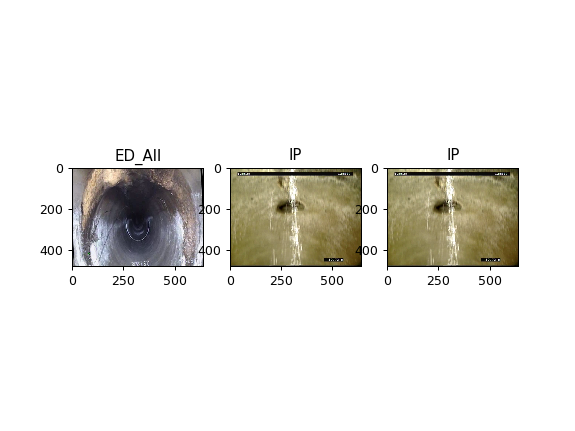

Left to right: ground truth samples from train, val test


In [26]:
for i, (train, val, test) in enumerate(zip(train_gen, val_gen, test_gen)):
    for data in (train, val, test):
        print(data[0].shape, data[1], (np.min(data[0]), np.max(data[0])))
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(postprocess(train[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(train[1])]))
#     plt.title(str(train[1]))
    
    plt.subplot(1, 3, 2)
    plt.imshow(postprocess(val[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(val[1])]))
    
    plt.subplot(1, 3, 3)
    plt.imshow(postprocess(test[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(test[1])]))
    
    if i >= 0:
        break
print("Left to right: ground truth samples from train, val test")        

In [27]:
# This cell intentionally left blank due to display bug above.

In [28]:
count_function = count_labels_single if caption_type == "single" else count_labels_multi

# for label, gen, coco, balanced_image_ids in zip(
#         ["train", "val", "test"],
#         [train_gen, val_gen, test_gen],
#         [coco_train, coco_val, coco_test],
#         [balanced_image_ids_train, balanced_image_ids_val, balanced_image_ids_test]):
#     data = gen_dump_data(gen, len(balanced_image_ids))
#     counter = count_function(data)
#     print(label, counter)

val_data = gen_dump_data(val_gen, len(balanced_image_ids_val))
test_data = val_data
class_weights = None
# Uncomment below line to use class weights, not needed if using balanced_set
# class_weights = calc_class_weights(gen_dump_data(train_gen, len(balanced_image_ids_train)), caption_type)

print("training class weights:")
print(class_weights)

print("Binary accuracy if you were to output all 0s")
print((val_data[1] == 0).sum(axis=0) / val_data[1].shape[0])
print((val_data[1] == 0).sum() / val_data[1].size)
print("percent of data covered by class", val_data[1].sum(axis=0) / val_data[1].shape[0])

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


training class weights:
None
Binary accuracy if you were to output all 0s
[0.85245902 0.57377049 0.93442623 0.80327869 0.83606557]
0.8
percent of data covered by class [0.14754098 0.42622951 0.06557377 0.19672131 0.16393443]


# Setup model

In [37]:
import tensorflow as tf

def add_model_regularization(model, kernel_regularizer_l2, activity_regularizer_l1):
    # Add L2 Regularization
    # Skip gamma and beta weights of batch normalization layers.
    if kernel_regularizer_l2:
        reg_losses = [
            keras.regularizers.l2(kernel_regularizer_l2)(w) / tf.cast(tf.size(w), tf.float32)
            for w in model.trainable_weights
            if not any([l in w.name for l in ['gamma', 'beta']])]
        model.add_loss(tf.add_n(reg_losses, name='l2_reg_loss'))
    if activity_regularizer_l1:
        reg_losses = [
            keras.regularizers.l1(activity_regularizer_l1)(
                layer.get_output_at(0)) / tf.cast(tf.size(layer.get_output_at(0)), tf.float32)
            for layer in model.layers
            if layer.trainable and not any([l in layer.name for l in ['class_logits', 'batch_norm']])]
        model.add_loss(tf.add_n(reg_losses, name='l1_reg_loss'))
    
def create_new_head(
    base_model, num_classes, caption_type, model_params, opt_params=None):
    '''make sure base_model has include_top=False. If loss=None then it is determined.'''
    from keras.regularizers import l1_l2
    if not opt_params:
        opt_params = {"optimizer": Nadam(clipnorm=1)}
    
    if model_params.loss is None:
        if caption_type == "single":
            opt_params['loss'] = "categorical_crossentropy" 
        elif caption_type == "multi":
            # weights = np.array([
                # i[1] for i in sorted(model_params.class_weights.items())])[np.newaxis, ...] \
                # if model_params.class_weights else 1.0
            opt_params['loss'] = 'binary_crossentropy'
    else:
        opt_params['loss'] = model_params.loss
        
    if params.activation == None:
        if caption_type == "single":
            params.activation = "softmax" 
        else:
            params.activation = "sigmoid"
    
    # add a global spatial average pooling layer
    x = base_model.output
    
    if model_params.pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif model_params.pooling == 'max':
        x = GlobalMaxPooling2D()(x)
    else:
        x = Flatten()(x)
    x = BatchNormalization()(x)
    if model_params.dropout:
        x = Dropout(model_params.dropout)(x)

    for _ in range(model_params.num_hidden_layers):
        x = Dense(model_params.num_hidden_neurons, activation='relu',
                  kernel_initializer=keras.initializers.he_uniform())(x)
        x = BatchNormalization()(x)
        if model_params.dropout:
            x = Dropout(model_params.dropout)(x)

    predictions = Dense(
        num_classes,
        activation=params.activation,
        kernel_initializer=keras.initializers.he_uniform(),
#         bias_initializer=keras.initializers.he_uniform(),
        name='class_logits')(x)

    for layer in base_model.layers:
        layer.trainable = model_params.train_features
    model = Model(inputs=base_model.input, outputs=predictions)
    
#     add_model_regularization(model, params.kernel_regularizer_l2, params.activity_regularizer_l1)
    
    for layer in model.layers: #Save 
        if not layer.trainable or 'batch_norm' in layer.name:
            continue
        if hasattr(layer, 'kernel_regularizer') and model_params.kernel_regularizer_l2:
            if 'kernel' in layer.weights[0].name:
                size = np.product(layer.weights[0].shape.as_list())
                if size:
                    layer.kernel_regularizer = l1_l2(0, model_params.kernel_regularizer_l2 / size)
        if hasattr(layer, 'activity_regularizer') and model_params.activity_regularizer_l1:
            if 'class_logits' in layer.name:
                size = np.product(layer.get_output_shape_at(0)[1:])
                if size:
                    layer.activity_regularizer = l1_l2(model_params.activity_regularizer_l1 / size, 0)
            
    model_config = model.get_config()
    model_weights = model.get_weights()
    model = Model.from_config(model_config)
    model.set_weights(model_weights)
    
    print("Compiling model:")
    print("   activation:", params.activation)
    print("   optimizer:", opt_params)
    model.compile(**opt_params, metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [31]:
for layer in model.layers[5:6]:
    size = np.product(layer.weights[0].shape.as_list())
    print(layer, (size))

NameError: name 'model' is not defined

In [32]:
def get_gradients(model):
    """Get the gradients of the loss with respect to the weights."""
    weights = [tensor for tensor in model.trainable_weights 
               if model.trainable_weights]
    return weights, model.optimizer.get_gradients(model.total_loss, weights)

def evaluate_model(model, test_data, thresh=0.5):
    def multi_label_decision(y_true, y_pred):
        return (y_true > thresh) == (y_pred > thresh)
    def single_label_decision(y_true, y_pred):
        return np.argmax(y_true, axis=-1) == np.argmax(y_pred, axis=-1)
    decision_function = single_label_decision if caption_type == 'single' else multi_label_decision

    Y_true = test_data[1]
    Y_pred = model.predict(test_data[0])
    TP = decision_function(Y_true, Y_pred)
    acc = np.count_nonzero(TP) / TP.size
    
    print("Test using {:d} samples:".format(len(test_data[0])))
    print("accuracy", acc)
    return Y_true, Y_pred, TP

def display_performance(Y_true, Y_pred, TP):
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_true[:, i],
                                                            Y_pred[:, i])
        average_precision[i] = average_precision_score(Y_true[:, i], Y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_true.ravel(),
        Y_pred.ravel())
    average_precision["micro"] = average_precision_score(Y_true, Y_pred,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    z = np.all((Y_pred > 0.5) == Y_true, axis=1)
    acc = np.count_nonzero(z) / z.size
    print("exact accuracy", acc)
    z = ((Y_pred > 0.5) == Y_true)
    acc = np.count_nonzero(z) / z.size
    print("binary accuracy", acc)
    
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(8, 10))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))

    for i, color in zip(range(num_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('{0} (area = {1:0.2f})'
                      ''.format(caption_map_r[i], average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Micro Average Precision vs. Recall')
    plt.legend(lines, labels, loc=(0, -.4), prop=dict(size=14))
    plt.show()
    plt.savefig(model_plot_path, dpi=150)
    
def save_model(model, name, class_map_r, prediction_type,
               model_weights_path, model_def_path, model_info_path, history,
               test_metrics=None, description=""):
    from abyss.utils import JsonNumpyEncoder
    def merged(a, b):
        merged = dict(a)
        merged.update(b)
        return merged
        
    model_info = {
        "name": name,
        "description": description,
        "weights": model_weights_path,
        "prediction_type": caption_type,
        "model": model_def_path,
        "classes": class_map_r,
        "architecture": {
            "backbone": "inceptionv3",
            "logit_activation": model.get_layer("class_logits").activation.__name__,
            "input_shape": image_dims
        },
        "metrics": {
            "loss_function": str(history.model.loss),
            "train": merged(
                history.history,
                {
                    "epoch": history.epoch,
                    "params": history.params
                })
        }
    }
    if test_metrics:
        model_info['metrics']['test'] = test_metrics
    
    print("Writing model def to " + model_def_path)
    with open(model_def_path, "w") as file:
        file.write(model.to_json())
        
    print("Writing model weights to " + model_weights_path)
    model.save_weights(model_weights_path)
    
    print("Writing model info to " + model_info_path)
    with open(model_info_path, "w") as file:
        file.write(json.dumps(model_info, cls=JsonNumpyEncoder))

# Model selection

In [43]:
def hamming_loss(y_true, y_pred):
    return K.mean(y_true * (1 - y_pred) + (1 - y_true) * y_pred)

def setup_callbacks(log_dir, hist=False):
    !mkdir -p "$log_dir/models"
    best_path = os.path.join(log_dir, "models/best.{epoch:03d}-{val_loss:.4f}.h5")
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, cooldown=0, verbose=1),# TODO patience 2?
        ModelCheckpoint(
            best_path, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=True, mode='auto', period=1),
            ModelCheckpoint(
                best_path, monitor='val_loss', verbose=1,
                save_best_only=False, save_weights_only=True, mode='auto', period=20),
        PRTensorBoard(
            log_dir=log_dir, 
            histogram_freq=(hist or 0), batch_size=batch_size,
            write_graph=True,
            write_grads=(hist is not None),
            write_images=False),
            EarlyStopping(
                monitor='val_loss', min_delta=0.0, patience=15, verbose=1, mode='auto')
    ]
    return callbacks

def go(epochs, class_weights, initial_epoch=0):
    return model.fit_generator(
        batching_gen(train_gen, batch_size=batch_size),
        validation_data=tuple(val_data),
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch_val,
        class_weight=class_weights,
        callbacks=callbacks, 
        epochs=epochs,
        verbose=1, initial_epoch=initial_epoch, workers=10)

def check_gradients(model):
    grad_test = None
    for image, label in train_gen:
        grad_test = (image, label)
        break
    rates = []
    weights, grads = get_gradients(model)
    feed_dict = {
        "class_logits_sample_weights:0": np.ones(2),
        "input_1:0": grad_test[0][np.newaxis, ...],
        "class_logits_target:0": grad_test[1][np.newaxis, ...]
    }
    for i, (w, g) in enumerate(zip(weights, grads)):
        if 'bias' in w.name:
            continue
        grad_norm = np.linalg.norm(g.eval(feed_dict, K.get_session()))
        weight_norm = np.linalg.norm(w.eval(K.get_session()))
        rate = grad_norm / weight_norm
        rates.append(rate)
    if np.mean(rates) < 5e-4 or np.mean(rates) > 3e-1: # These values change with network structure
        print("Bad gradients ({:.3e}).".format(np.mean(rates)))
        return False
    return True

In [44]:
# Modify this class to change search parameters
class ExperimentParameters(object):
    def __init__(self, data_name, batch_size):
        from keras.regularizers import l1_l2
        self.data_name = data_name
        self.feature_extractor = np.random.choice([VGG16, ResNet50, InceptionV3])
        self.model_name = self.feature_extractor.__name__
        self.learning_rate = 10 ** np.random.uniform(-8, -4)
        self.loss = 'binary_crossentropy'
        self.dropout = 0.5
        self.train_features = bool(np.random.binomial(1, 0.5))
        self.pooling = np.random.choice(['avg', 'max'])
        self.num_hidden_layers = int(np.random.choice([0, 1], size=1, p=(0.5, 0.5)))
        self.num_hidden_neurons = 1024
        self.pretrained_weights = np.random.choice(['imagenet', None])
        self.class_weights = None
        self.batch_size = batch_size
        self.kernel_regularizer_l2 = 10 ** np.random.uniform(-3, -1)
        self.activity_regularizer_l1 = 10 ** np.random.uniform(-3, -1)
        self.id = str(np.random.randint(0, 9999))
        self.activation = 'softmax'

    def experiment_name(self):
        return str(self)
    
    @staticmethod
    def from_string(string):
        from keras.regularizers import l1_l2
        strs = dict(([tuple(field.split(':')) for field in string.split(' ') if len(field.split(':')) == 2]))
        params = ExperimentParameters(strs['data'], int(strs['batchsize']))
        params.model_name = strs['model']
        params.num_hidden_layers, params.num_hidden_neurons = [int(s) for s in strs['head'].split('x')]
        params.train_features = strs['data'] == 'all'
        params.pretrained_weights = strs['from']
        params.activation = strs['activation']
        params.loss = strs['loss']
        params.learning_rate = float(strs['init_lr'])
        params.kernel_regularizer_l2 = float(strs['act_reg'])
        params.activity_regularizer_l1 = float(strs['ker_reg'])
        params.dropout = float(strs['dropout'])
        params.pool = bool(strs['pool'])
        params.class_weights = strs['CW'] == 'True'
        params.id = strs['id']
        if params.class_weights:
            raise NotImplementedError("Have not yet serialized class weights")
        return params
    
    def __str__(self):
        self.model_name = self.feature_extractor.__name__
        return ' '.join([
            ':'.join([key, str(value)]) 
            for key, value in [
                ("id", self.id),
                ("data", self.data_name),
                ("batchsize", self.batch_size),
                ("activation", self.activation),
                ("model", self.model_name),
                ("head", "{:d}x{:d}".format(self.num_hidden_layers, self.num_hidden_neurons)),
                ("train", 'all' if self.train_features else 'heads'),
                ("from", str(self.pretrained_weights)),
                ("loss", self.loss.__name__ if callable(self.loss) else str(self.loss)),
                ("init_lr", "{:.3e}".format(self.learning_rate)),
                ("act_reg", "{:.3e}".format(self.activity_regularizer_l1)),
                ("ker_reg", "{:.3e}".format(self.kernel_regularizer_l2)),
                ("dropout", "{:.1f}".format(self.dropout or 0)),
                ("pool", str(self.pooling)),
                ("CW", str(True if self.class_weights else False))]])

In [35]:
def check_sigmoid(model, val_data):
    activations = []
    kernels = []
    feed_dict = {
            "class_logits_sample_weights:0": np.ones(2),
            "input_1:0": val_data[0][:2],
            "class_logits_target:0": val_data[1][:2]
        }
    for layer_idx, layer in enumerate(model.layers[-3:]):
        print(layer.name)
        activations = layer.get_output_at(0).eval(feed_dict=feed_dict, session=K.get_session())
    #     for weight, value in zip(layer.weights, layer.get_weights()):
    #         if 'conv' not in weight.name.lower():
    #             continue
    #         print(weight, K.eval(weight).shape)
        print("activations", [func(activations) for func in [np.min, np.mean, np.max, np.std]])
        


Compiling model:
   activation: sigmoid
   optimizer: {'optimizer': <keras.optimizers.Nadam object at 0x7fd93c1c2c18>, 'loss': 'binary_crossentropy'}
id:2408 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:1.000e-02 ker_reg:1.000e-03 dropout:0.5 pool:avg CW:False
Training: 4 layers
/data/log/cnn/fd/monday3/id:2408 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:1.000e-02 ker_reg:1.000e-03 dropout:0.5 pool:avg CW:False
Epoch 1/2


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


89/89 [==============================] - 43s 485ms/step - loss: 0.9235 - binary_accuracy: 0.4858 - categorical_accuracy: 0.2427 - val_loss: 0.6767 - val_binary_accuracy: 0.5705 - val_categorical_accuracy: 0.0984

Epoch 00001: val_loss improved from inf to 0.67673, saving model to /data/log/cnn/fd/monday3/id:2408 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:1.000e-02 ker_reg:1.000e-03 dropout:0.5 pool:avg CW:False/models/best.001-0.6767.h5
Epoch 2/2
89/89 [==============================] - 37s 420ms/step - loss: 0.6268 - binary_accuracy: 0.6926 - categorical_accuracy: 0.2764 - val_loss: 0.5049 - val_binary_accuracy: 0.7934 - val_categorical_accuracy: 0.2131

Epoch 00002: val_loss improved from 0.67673 to 0.50492, saving model to /data/log/cnn/fd/monday3/id:2408 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-0


Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 00021: val_loss did not improve
Epoch 00021: early stopping
Test using 61 samples:
accuracy 0.8032786885245902
Average precision score, micro-averaged over all classes: 0.40
exact accuracy 0.11475409836065574
binary accuracy 0.8032786885245902


<IPython.core.display.Javascript object>


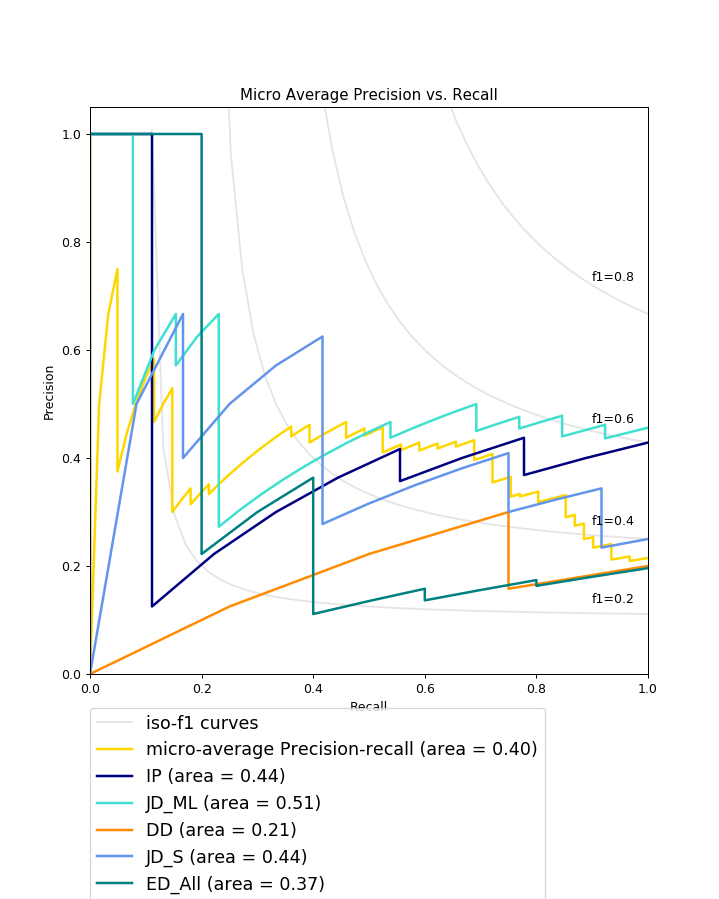

Writing model def to /data/log/cnn/fd/monday3/id:2408 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:1.000e-02 ker_reg:1.000e-03 dropout:0.5 pool:avg CW:False/model_def.json
Writing model weights to /data/log/cnn/fd/monday3/id:2408 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:1.000e-02 ker_reg:1.000e-03 dropout:0.5 pool:avg CW:False/model_weights.h5
Writing model info to /data/log/cnn/fd/monday3/id:2408 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:1.000e-02 ker_reg:1.000e-03 dropout:0.5 pool:avg CW:False/model.json


In [42]:
search_output_dir = "/data/log/cnn/fd/monday3" # Change this output dir.
history_data = {}

for attempt_no in range(1):
    K.clear_session()
    params = ExperimentParameters(dataset_name, batch_size)
    params.feature_extractor = VGG16
    params.activity_regularizer_l1 = 0.05
    params.kernel_regularizer_l2 = 0.01
    params.learning_rate = 1e-3
    params.activation = 'sigmoid'
    params.num_hidden_layers = 0
    params.pooling = 'avg'
    params.train_features = False
    params.pretrained_weights = 'imagenet'
    base_model = params.feature_extractor(include_top=False, weights=params.pretrained_weights, input_shape=image_dims)
    model = create_new_head(
        base_model, num_classes, caption_type, params, 
        opt_params={'optimizer': Nadam(clipnorm=1, clipvalue=1)}
    )

    experiment_name = str(params)# + "-{:03d}".format(np.random.randint(0, 999))
    log_dir = os.path.join(search_output_dir, experiment_name)
    model_def_path = os.path.join(log_dir, "model_def.json")
    model_weights_path = os.path.join(log_dir, "model_weights.h5")
    model_info_path = os.path.join(log_dir, "model.json")
    model_plot_path = os.path.join(log_dir, "precision-recall.png")
    print(experiment_name)
    print("Training: {:d} layers".format(len([1 for layer in model.layers if layer.trainable])))
    print(log_dir)
    
    callbacks = setup_callbacks(log_dir, hist=1)
    K.set_value(model.optimizer.lr, params.learning_rate)
    for i in range(0, 10, 2):
        history_data[experiment_name] = go(i+2, params.class_weights, initial_epoch=i)
#         check_sigmoid(model, val_data)
    callbacks = setup_callbacks(log_dir, hist=20)
    history_data[experiment_name] = go(100-3, params.class_weights, initial_epoch=10)

#     if not check_gradients(model): # Disabled as I only know what to expect for VGG16
#         print("Bad gradients. Continuing to next model.")

    (Y_true, Y_pred, TP) = evaluate_model(model, test_data, thresh=0.5)
    display_performance(Y_true, Y_pred, TP)
    
    save_model(
        model, name=experiment_name,
        class_map_r=caption_map_r, prediction_type=caption_type,
        model_weights_path=model_weights_path, model_def_path=model_def_path, model_info_path=model_info_path,
        test_metrics=None, history=history_data[experiment_name],
        description="Test model for 5 FDs"
    )
if history_data:
    with open(os.path.join(search_output_dir, "history-60epoch.pkl"), "wb") as file:
        pickle.dump({key: history.history for key, history in history_data.items()}, file)
### Should you need to load this pkl:
# with open(os.path.join(search_output_dir, "history-100epoch.pkl"), "rb") as file:
#     history = pickle.load(file)

In [ ]:
lrs = [key[1] for key, val  in sorted(history_data.items(), key=lambda x: x[0])]
val_loss = [history.history['val_loss'][-1] for key, history  in sorted(history_data.items(), key=lambda x: x[0])]
loss = [history.history['loss'][-1] for lr, history  in sorted(history_data.items(), key=lambda x: x[0])]
acc = [history.history['binary_accuracy'][-1] for lr, history  in sorted(history_data.items(), key=lambda x: x[0])]
val_acc = [history.history['val_binary_accuracy'][-1] for lr, history  in sorted(history_data.items(), key=lambda x: x[0])]

plt.figure()
plt.subplot(1, 2, 1)
plt.semilogx(lrs, loss, '.b', label='loss')
plt.semilogx(lrs, val_loss, '.r', label='val_loss')
plt.legend()
plt.title("Loss Vs. LR (100 Epoch)")
plt.subplot(1, 2, 2)
plt.semilogx(lrs, acc, '.b', label='binary_accuracy')
plt.semilogx(lrs, val_acc, '.r', label='val_binary_accuracy')
plt.legend()
plt.title("Accuracy Vs. LR (100 Epoch)")
plt.tight_layout()

# Continue training specific model

In [49]:
search_output_dir = "/data/log/cnn/fd/monday3" # Change this output dir.
model_instance = "id:7315 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:0.000e+00 ker_reg:0.000e+00 dropout:0.5 pool:avg CW:False"
model_best_weight = "model_weights.h5"
model_initial_learning_rate = 5e-7 ##### IMPORTANT TO SET THIS FROM TENSORBOARD
num_epoch = 200
class_weights = None # Can't currently resume training with imbalance data #TODO

params = ExperimentParameters.from_string(model_instance)
params.train_features = True
params.id = "{:s}-{:d}".format(str(params.id), np.random.randint(0,99))
model_weights_in_path = os.path.join(search_output_dir, model_instance, model_best_weight)
log_dir = os.path.join(search_output_dir, model_instance, "continued")
best_path = os.path.join(log_dir, "models/best.{epoch:03d}-{val_loss:.4f}.h5")
model_def_path = os.path.join(log_dir, "model_def.json")
model_info_path = os.path.join(log_dir, "model.json")
model_plot_path = os.path.join(log_dir, "precision-recall.png")

print(model_weights_in_path)
if os.path.exists(model_weights_in_path):
    !mkdir -p "$log_dir/models"
else:
    raise OSError("path does not exist")
    
# plt.figure()
# from skimage.io import imread
# plt.imshow(imread(os.path.join(log_dir, "../precision-recall.png")))
print("loading")
print(os.path.join(search_output_dir, model_instance, "model.json"))
model = None
K.clear_session()
model = Inference(os.path.join(search_output_dir, model_instance, "model.json")).model
model.load_weights(os.path.join(search_output_dir, model_instance, "model_weights.h5"))
add_model_regularization(model, 0.01, 0.01)

for layer in model.layers:
    layer.trainable = params.train_features

model.compile( # TODO, load this from JSON, manually change this if you are doing single label
    Nadam(clipnorm=1),
    loss=params.loss,
    metrics=['binary_accuracy', 'categorical_accuracy'])

print("Training: {:d} layers".format(len([1 for layer in model.layers if layer.trainable])))
print(log_dir)

/data/log/cnn/fd/monday3/id:7315 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:0.000e+00 ker_reg:0.000e+00 dropout:0.5 pool:avg CW:False/model_weights.h5
loading
/data/log/cnn/fd/monday3/id:7315 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:0.000e+00 ker_reg:0.000e+00 dropout:0.5 pool:avg CW:False/model.json
Training: 23 layers
/data/log/cnn/fd/monday3/id:7315 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:0.000e+00 ker_reg:0.000e+00 dropout:0.5 pool:avg CW:False/continued


In [ ]:
callbacks = setup_callbacks(log_dir, hist=2)
K.set_value(model.optimizer.lr, model_initial_learning_rate)

history_data[experiment_name] = go(num_epoch, class_weights, initial_epoch=20)
(Y_true, Y_pred, TP) = evaluate_model(model, test_data, thresh=0.5)
display_performance(Y_true, Y_pred, TP)

save_model(
    model, name=experiment_name,
    class_map_r=caption_map_r, prediction_type=caption_type,
    model_weights_path=model_weights_path, model_def_path=model_def_path, model_info_path=model_info_path,
    test_metrics=None, history=history_data[experiment_name],
    description="Test model for 5 FDs"
)

Epoch 21/200


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


89/89 [==============================] - 48s 543ms/step - loss: 0.4397 - binary_accuracy: 0.8270 - categorical_accuracy: 0.4719 - val_loss: 0.4457 - val_binary_accuracy: 0.8230 - val_categorical_accuracy: 0.4918

Epoch 00021: val_loss improved from inf to 0.44574, saving model to /data/log/cnn/fd/monday3/id:7315 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy init_lr:1.000e-03 act_reg:0.000e+00 ker_reg:0.000e+00 dropout:0.5 pool:avg CW:False/continued/models/best.021-0.4457.h5
Epoch 22/200
89/89 [==============================] - 47s 523ms/step - loss: 0.4697 - binary_accuracy: 0.8094 - categorical_accuracy: 0.4022 - val_loss: 0.4425 - val_binary_accuracy: 0.8197 - val_categorical_accuracy: 0.4918

Epoch 00022: val_loss improved from 0.44574 to 0.44252, saving model to /data/log/cnn/fd/monday3/id:7315 data:ours batchsize:5 activation:sigmoid model:VGG16 head:0x1024 train:heads from:imagenet loss:binary_crossentropy ini

In [ ]:
model.losses

In [ ]:
layer=model.layers[-3]
print(layer)
for weight in layer.weights:
    weight.initializer.run(session=K.get_session())
# w = layer.get_weights()
# plt.figure()
# plt.hist(w[0].ravel(), bins=100)

In [ ]:
# More training
K.set_value(model.optimizer.lr, 1e-4)

go(300, class_weights, initial_epoch=200)
(Y_true, Y_pred, TP) = evaluate_model(model, test_data, thresh=0.5)
display_performance(Y_true, Y_pred, TP)

# save_model(
#     model, name=experiment_name + "-second",
#     class_map_r=caption_map_r, prediction_type=caption_type,
#     model_weights_path=model_weights_path, model_def_path=model_def_path, model_info_path=model_info_path,
#     test_metrics=None, history=history_data[experiment_name],
#     description="Test model for 5 FDs"
# )

# Below is untested with new changes, don't use

# Model Testing

In [ ]:
from herbicide.utils import vis_square
TP_mask = np.logical_and.reduce(TP, axis=1)
right = test_data[0][TP_mask]
wrong = test_data[0][~TP_mask]
wrong.shape
plt.figure()
vis_square(wrong)
plt.title("Incorrectly Predicted")
plt.figure()
vis_square(right)
plt.title("Correctly Predicted")

# Binary coded the labels then count them wrt TP/FP
print("num labels", test_data[1].sum(axis=0))
coded = np.sum(test_data[1][~TP_mask] * 2 ** np.arange(num_classes)[::-1], axis=1).astype(int)
print("binary coded class error count:", dict(sorted(Counter(coded).items(), key=lambda x: x[0])))
coded = np.sum(test_data[1][TP_mask] * 2 ** np.arange(num_classes)[::-1], axis=1).astype(int)
print("binary coded class correct count:", dict(sorted(Counter(coded).items(), key=lambda x: x[0])))
print(Y_pred[TP_mask])

# Learning Curve

In [ ]:
def learning_curve(dataset, lr, steps, val_data, log_dir):
    def save_model(path):
        print("Saving", path)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        model.save_weights(path)
    def setup_callbacks():
        return [
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, cooldown=5, verbose=1),
                ModelCheckpoint(
                    model_best_path, monitor='val_loss', verbose=1,
                    save_best_only=True, save_weights_only=True, mode='auto', period=1),
#                 ModelCheckpoint(
#                     best_path, monitor='val_loss', verbose=1,
#                     save_best_only=False, save_weights_only=True, mode='auto', period=50),
                PRTensorBoard(
                    log_dir=model_log_dir,
                    histogram_freq=0,
                    batch_size=batch_size,
                    write_graph=False,
                    write_grads=False,
                    write_images=False),
        #         EarlyStopping(
        #             monitor='val_loss', min_delta=0.0, patience=40, verbose=1, mode='auto')
        ]
    def create_new_model(load_base=False):
        K.clear_session()
        model = create_new_head(
            InceptionV3(include_top=False, weights='imagenet', input_shape=image_dims),
            num_classes, caption_type, opt_params={'optimizer': Nadam()},
            class_weights=None, train_features=False, l2_reg=None)
        if load_base:
            print("Loading base model")
            model.load_weights(base_model_path, by_name=True)
        return model

    def train():
        print("Training")
        K.set_value(model.optimizer.lr, lr)
        history[subset_size] = model.fit_generator(
            batching_gen(gen, batch_size=batch_size),
            validation_data=tuple(val_data),
            steps_per_epoch=(subset_size // batch_size),
            validation_steps=steps_per_epoch_val,
            class_weight=model_class_weights,
            callbacks=setup_callbacks(), 
            epochs=50,
            verbose=1)
    model_class_weights = None
    model = None
    model_path = None
    image_ids = [image['id'] for image in dataset.imgs.values()]
    np.random.shuffle(image_ids)
    num_images = len(image_ids)
    print("num_images", num_images)
    history = {}
    base_model_path = os.path.join(log_dir, "base", "weights.h5")
    model_path = base_model_path
    for subset_size in np.linspace(0, num_images, steps + 1).astype(int):
        if subset_size > 0:
            imgIds = image_ids[:subset_size]
            gen = pipeline(
                dataset.generator(shuffle_ids=False, imgIds=imgIds),
                aug_config=None)
            model_class_weights = calc_class_weights(gen, dataset) # TODO

            model_path = os.path.join(log_dir, "subset-of-{:d}/weights.h5".format(subset_size))
            model_log_dir = os.path.dirname(model_path)
            model_best_path = os.path.join(log_dir, "subset-of-{:d}/best.h5".format(subset_size))
            os.makedirs(model_log_dir, exist_ok=True)

            print("learning curve(lr={:.3e}, size={:d})".format(lr, subset_size))
            print("model_log_dir", model_log_dir)
            print("training class weights")
            print(model_class_weights)
        model = create_new_model(load_base=(subset_size > 0))
        if subset_size:
            train()
        save_model(model_path)
    return history

model = None
lr = 1e-5
learning_curve_dir = "/data/log/cnn/fd/learning_curve_5--{:.2e}".format(lr)
lc_history = learning_curve(coco_train, lr, 5, val_data, learning_curve_dir)
val_loss = np.array([(size, h.history['val_loss'][-1]) for size, h in lc_history.items()])
train_loss = np.array([(size, h.history['loss'][-1]) for size, h in lc_history.items()])
plt.figure()
plt.plot(train_loss[:, 0], train_loss[:, 1], 'b.')
plt.plot(val_loss[:, 0], val_loss[:, 1], 'r.')
plt.xlabel("Number of Training Samples")
plt.ylabel("Loss")
plt.savefig(os.path.join(learning_curve_dir, "plot.png"), dpi=150)

In [ ]:
# !rm -R /data/log/cnn/fd/learning-curve/

In [ ]:
images = None
for images, labels in batching_gen(train_gen, batch_size=batch_size):
    print(images.shape, labels.shape)
    
    pred = model.predict(images)
    print(labels)
    print(pred)
    print(K.eval(K.tf.losses.sigmoid_cross_entropy(labels, pred)))
    break

In [ ]:
for unique_label in np.unique(val_data[1], axis=0):
    unique_data = [val_data[0][i] for i in range(len(val_data[0])) if np.all(val_data[1][i] == unique_label)]
    num_data = len(unique_data)
    print(unique_label, num_data)
    plt.figure()
    vis_square(np.array(unique_data))
    plt.title(unique_label)

# Check Update/Weight Ratio

In [ ]:

for i, (w, g) in enumerate(zip(weights, grads)):
    grad_norm = np.linalg.norm(g.eval(feed_dict, K.get_session()))
    weight_norm = np.linalg.norm(w.eval(K.get_session()))
    rate = grad_norm / weight_norm
    print(i, rate)


# Visualize filters

In [ ]:
from herbicide.utils import vis_square
for layer in model.layers:
    if not layer.trainable_weights:
        continue
    for weight in layer.trainable_weights: #  Assumes FD is not trainable
        if 'kernel' not in weight.name:
            continue
        print(weight.name)
        value = K.eval(weight.value())
        print(value.shape)
    
    plt.figure()
    vis_square(value.transpose((3, 0, 1, 2)))
    break


In [ ]:
caption_stats = []
for i, (image, caption) in enumerate(coco_train.generator(imgIds=balanced_image_ids_train)):
    plt.figure()
    plt.imshow(image)
    plt.title(str(caption))
    if i == 10:
        break
    caption_stats.append(caption)

In [ ]:
np.array(caption_stats)